# Entwicklungsnotebook

Werkstatt, um Umsetzungen zum Quantenschaltungssimulator auszuprobieren.

In [59]:
import numpy as np
from cmath import isclose, phase, pi
import math
import matplotlib.pyplot as plt

In [60]:
class QState:
    def __init__(self, n):
        self.n = n
        self.state = np.zeros(2**n, dtype=complex)
        self.state[0] = 1 # Initialisierung auf Wert 0
    
    def op(self, operator, i = 0):
        eyeL = np.eye(2**i, dtype=complex)
        eyeR = np.eye(2**(self.n - i - int(math.log(operator.shape[0], 2))), dtype=complex)
        self.state = np.kron(np.kron(eyeL, operator), eyeR) @ self.state
        return self
    
    def isvalid(self):
        return isclose(self.state @ np.conjugate(self.state), 1.0)
    
    def __repr__(self):
        repr = f"{self.__class__.__name__}({self.n}) valid = {self.isvalid()}:"
        for i in range(0, self.state.shape[0]):
            num = self.state[i]
            repr += f"\n{i:2d} |{i:0{self.n}b}⟩ "
            repr += f"{num.real if isclose(num.imag, 0.0) else (f'{num.imag}i' if isclose(num.real, 0.0) else f'{num.real} + {num.imag}i')} "
            repr += f"({abs(num):.4f} * e^{phase(num) / pi * 180.0:.2f}°) "
            repr += f"{abs(num * num):.2%}"
        return repr
    
    def show(self):
        print(self)
        return self
    
    def plot(self):
        names = list(map(lambda x: f'|{x}⟩', range(0, self.state.shape[0])))
        values = list(map(lambda x: abs(x), self.state * self.state))
        plt.bar(names, values)
        plt.suptitle(f'{self.__class__.__name__}({self.n})')
        plt.show()
        return self

In [61]:
QState(3)

QState(3) valid = True:
 0 |000⟩ 1.0 (1.0000 * e^0.00°) 100.00%
 1 |001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

Mit dieser Änderung von `__init__` kann ein Dictionary übergeben werden, das angibt, welches Qubit wie initialisiert werden soll. Per default wird jedes Qubit auf $|0\rangle$, d.h. `np.array([1, 0])` gesetzt. Der Kopf der Initialisierungsmethode zeigt beispielhaft, wie ein solches Dictionary aufgebaut ist. Die Zählung der Qubits beginnt bei 0.

In [62]:
class QState(QState):
    def __init__(self, n, qubitState = {0: np.array([1, 0])}):
        self.n = n
        self.state = np.array([1], dtype=complex)
        for qubit in range(0,n):
            self.state = np.kron(self.state, qubitState.get(qubit, np.array([1, 0])))

In [63]:
QState(3)

QState(3) valid = True:
 0 |000⟩ 1.0 (1.0000 * e^0.00°) 100.00%
 1 |001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [64]:
QState(3, {1: np.array([0,1]), 2: np.array([0,1])})

QState(3) valid = True:
 0 |000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 1 |001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |011⟩ 1.0 (1.0000 * e^0.00°) 100.00%
 4 |100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

Aufsetzen einiger Gates für die folgende Simulation.

In [65]:
SWAP = np.array([[1,0,0,0],
                 [0,0,1,0],
                 [0,1,0,0],
                 [0,0,0,1]])
SWAP

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1]])

In [66]:
X = PAULIX = np.array([[0,1],
                   [1,0]])
PAULIX

array([[0, 1],
       [1, 0]])

In [67]:
CNOT = np.array([[1,0,0,0],
                 [0,1,0,0],
                 [0,0,0,1],
                 [0,0,1,0]])
CNOT

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [68]:
TOFFOLI = np.array([[1,0,0,0,0,0,0,0],
                    [0,1,0,0,0,0,0,0],
                    [0,0,1,0,0,0,0,0],
                    [0,0,0,1,0,0,0,0],
                    [0,0,0,0,1,0,0,0],
                    [0,0,0,0,0,1,0,0],
                    [0,0,0,0,0,0,0,1],
                    [0,0,0,0,0,0,1,0]])
TOFFOLI

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0]])

## Simulation

In [69]:
from cmath import sqrt

In [70]:
q = QState(4, {0: np.array([1/sqrt(2), 1/sqrt(2)]),
               1: np.array([1/sqrt(2), 1/sqrt(2)])})
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [71]:
q = q.op(PAULIX, 0).op(PAULIX, 1)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [72]:
q = q.op(SWAP, 1).op(CNOT).op(SWAP, 1)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

In [73]:
q = q.op(CNOT, 1)
q

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
13 |1101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%

QState(4) valid = True:
 0 |0000⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 1 |0001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 2 |0010⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 3 |0011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 4 |0100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 5 |0101⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 6 |0110⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
 7 |0111⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 8 |1000⟩ 0.0 (0.0000 * e^0.00°) 0.00%
 9 |1001⟩ 0.0 (0.0000 * e^0.00°) 0.00%
10 |1010⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
11 |1011⟩ 0.0 (0.0000 * e^0.00°) 0.00%
12 |1100⟩ 0.0 (0.0000 * e^0.00°) 0.00%
13 |1101⟩ 0.4999999999999999 (0.5000 * e^0.00°) 25.00%
14 |1110⟩ 0.0 (0.0000 * e^0.00°) 0.00%
15 |1111⟩ 0.0 (0.0000 * e^0.00°) 0.00%


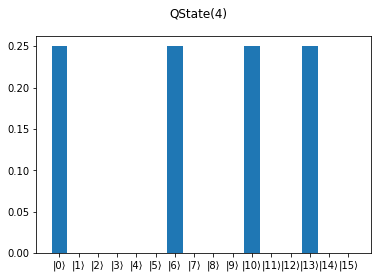

In [74]:
q = q.op(SWAP, 2).op(TOFFOLI).op(SWAP, 2).show().plot()